<a href="https://colab.research.google.com/github/BadAsiv/Homework/blob/main/XJTU/AdvAI/DLG_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

由于效果不太稳定，经测试将下面代码替换，才使梯度回传生效，因此或许与软件版本相关

梯度回传API
```python
# dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
# dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

dummy_data = torch.randn(gt_data.size(), requires_grad=True, device=device)
dummy_label = torch.randn(gt_onehot_label.size(), requires_grad=True, device=device)
```

环境检查

引入依赖

In [3]:
import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms

torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)


2.5.1+cu121 0.20.1+cu121


In [4]:
print("PyTorch版本:", torch.__version__)
print("CUDA是否可用:", torch.cuda.is_available())
print("CUDA版本:", torch.version.cuda)
print("GPU名称:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch版本: 2.5.1+cu121
CUDA是否可用: True
CUDA版本: 12.1
GPU名称: Tesla T4


数据加载、图像预处理和自定义损失函数

In [5]:
dst = datasets.CIFAR100('./torch', download=True)

#图像预处理
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

#张量转换为图像
tt = transforms.ToPILImage()

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

#将标签转换为one-hot编码
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

#计算one-hot编码的交叉熵
#为什么不直接用 F.cross_entropy？答：F.cross_entropy 适用于标签为整数的情况，而这里的自定义版本专门处理 One-Hot 编码 标签。
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

100%|██████████| 169M/169M [00:12<00:00, 13.2MB/s]


Extracting ./torch/cifar-100-python.tar.gz to ./torch
Running on cuda


In [6]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

net = LeNet().to(device)

net.apply(weights_init)
criterion = cross_entropy_for_onehot

GT label is 84. 
Onehot label is 84.


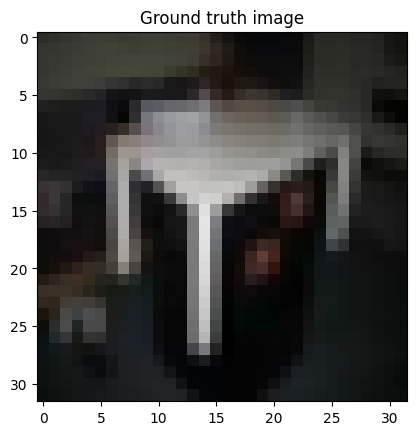

In [8]:
# 加载指定索引的图像与标签
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)


#图像可视化
plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

# compute original gradient
out = net(gt_data) #前向传播
y = criterion(out, gt_onehot_label) #计算损失
dy_dx = torch.autograd.grad(y, net.parameters())

# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))


对抗样本初始化

Dummy label is 64.


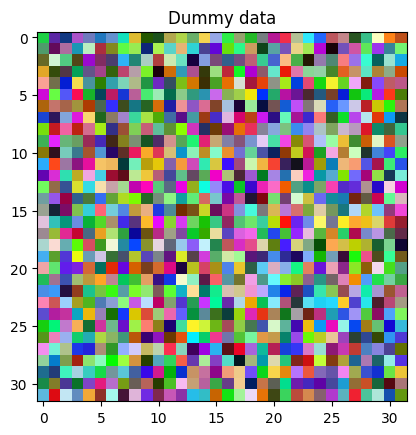

In [10]:
# 计算对抗样本
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [13]:
# 使用 LBFGS 优化器
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
history = []
loss_history = []

for iters in range(300):
    def closure():
        optimizer.zero_grad()
        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        return grad_diff

    grad_diff = optimizer.step(closure)  # 执行优化器步骤，grad_diff 是标量张量
    current_loss = float(grad_diff)  # 将 grad_diff 转为 float 类型

    if iters % 10 == 0:
        print("Loss at step %d: %.4f" % (iters, current_loss))
    history.append(tt(dummy_data[0].cpu()))
    loss_history.append(current_loss)


Loss at step 0: 13.0136
Loss at step 10: 0.8318
Loss at step 20: 0.2713
Loss at step 30: 0.1055
Loss at step 40: 0.0331
Loss at step 50: 0.0081
Loss at step 60: 0.0022
Loss at step 70: 0.0007
Loss at step 80: 0.0003
Loss at step 90: 0.0001
Loss at step 100: 0.0000
Loss at step 110: 0.0000
Loss at step 120: 0.0000
Loss at step 130: 0.0000
Loss at step 140: 0.0000
Loss at step 150: 0.0000
Loss at step 160: 0.0000
Loss at step 170: 0.0000
Loss at step 180: 0.0000
Loss at step 190: 0.0000
Loss at step 200: 0.0000
Loss at step 210: 0.0000
Loss at step 220: 0.0000
Loss at step 230: 0.0000
Loss at step 240: 0.0000
Loss at step 250: 0.0000
Loss at step 260: 0.0000
Loss at step 270: 0.0000
Loss at step 280: 0.0000
Loss at step 290: 0.0000


Latest Dummy label is 84.


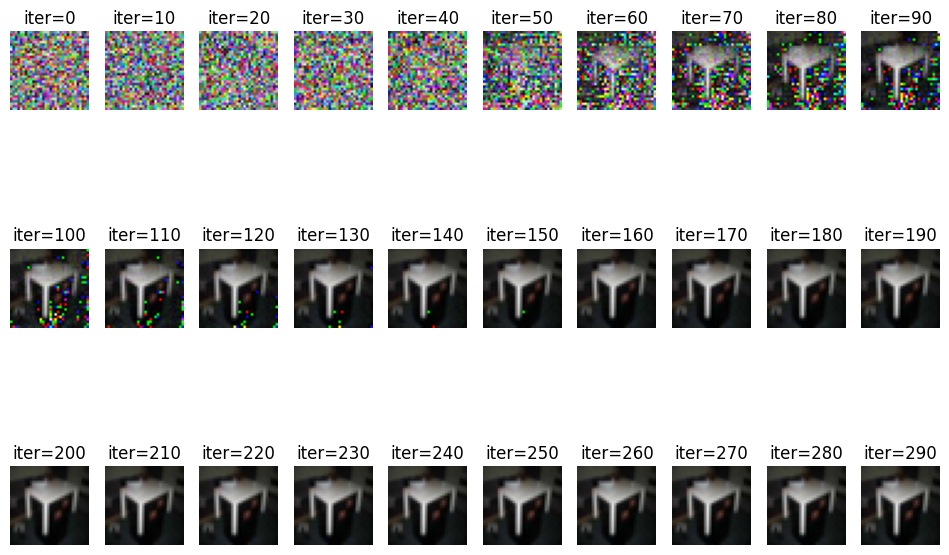

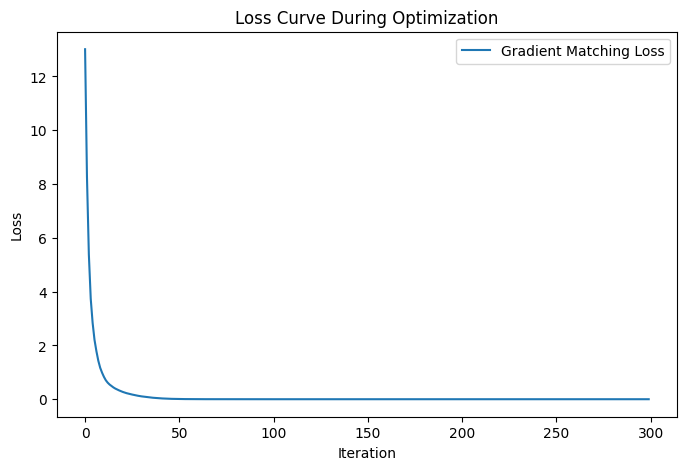

In [15]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i * 10])
  plt.title("iter=%d" % (i * 10))
  plt.axis('off')

print("Latest Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

# 绘制损失变化曲线
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Gradient Matching Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve During Optimization")
plt.legend()
plt.show()

完整代码

100%|██████████| 169M/169M [00:18<00:00, 9.01MB/s]


Extracting /root/data/cifar-100-python.tar.gz to /root/data
Running on cuda
GT label is 84.
Dummy label is 50.
Iteration 0, Loss: 29.002450942993164
Iteration 10, Loss: 0.8167032599449158
Iteration 20, Loss: 0.12276362627744675
Iteration 30, Loss: 0.023670820519328117
Iteration 40, Loss: 0.0062090009450912476
Iteration 50, Loss: 0.0020750691182911396
Iteration 60, Loss: 0.0007446996751241386
Iteration 70, Loss: 0.0003141151391901076
Iteration 80, Loss: 0.0001434919540770352
Iteration 90, Loss: 6.859783752588555e-05
Iteration 100, Loss: 3.4060834877891466e-05
Iteration 110, Loss: 1.8085003830492496e-05
Iteration 120, Loss: 1.044289911078522e-05
Iteration 130, Loss: 6.59415991322021e-06
Iteration 140, Loss: 4.520926268014591e-06
Iteration 150, Loss: 3.4815836897905683e-06
Iteration 160, Loss: 2.9388227176241344e-06
Iteration 170, Loss: 2.510492095098016e-06
Iteration 180, Loss: 2.484608330632909e-06
Iteration 190, Loss: 2.4846351607266115e-06
Iteration 200, Loss: 2.4846151518431725e-06
I

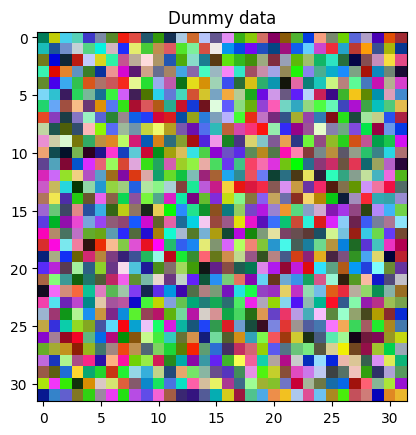

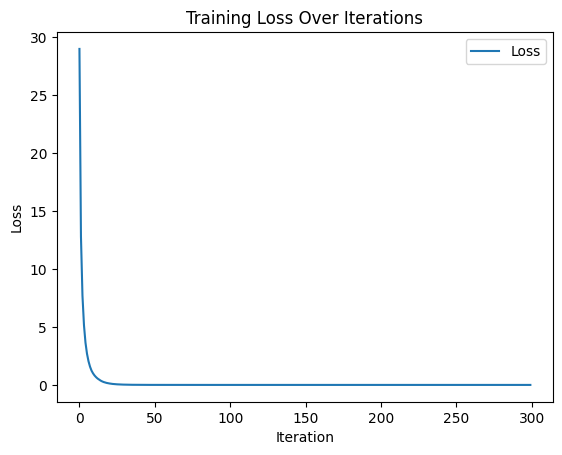

Dummy label is 84.


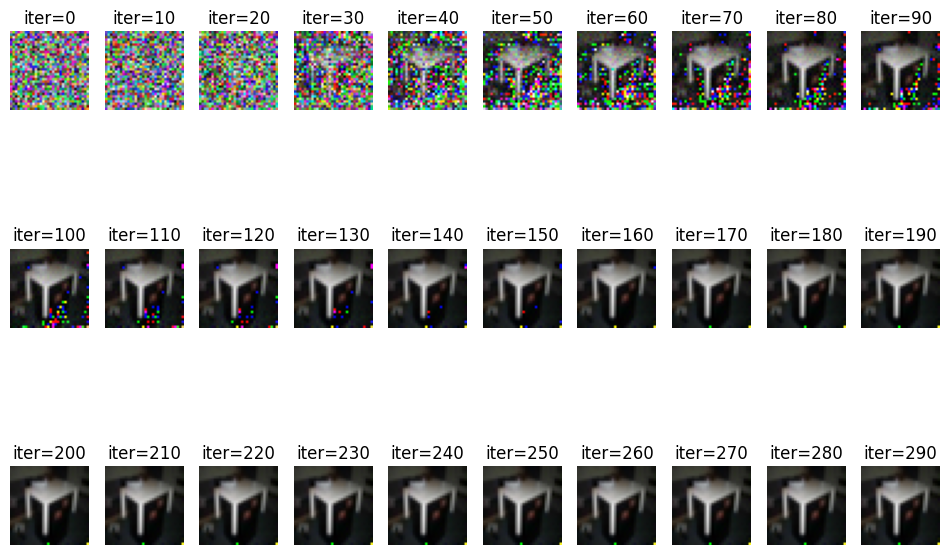

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 加载数据集
dst = datasets.CIFAR100("~/data", download=True)
tp = transforms.ToPILImage()
tt = transforms.ToTensor()

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on %s" % device)

# 标签转为 one-hot 编码
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

# 自定义 one-hot 交叉熵
# 使用 softmax 后的概率值计算交叉熵损失
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(-target * F.log_softmax(pred, dim=-1), 1))

# 初始化权重
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# 选择一张图片及其标签
img_index = 25
gt_data = tt(dst[img_index][0]).to(device)
gt_data = gt_data.unsqueeze(0)
gt_label = torch.tensor([dst[img_index][1]]).to(device)
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

# 可视化 Ground Truth 图像
plt.imshow(tp(gt_data[0].cpu()))
plt.title("Ground truth image")
print("GT label is %d." % gt_label.item())


# 计算真实梯度
y = criterion(net(gt_data), gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())
original_dy_dx = [_.detach().clone() for _ in dy_dx]

# 生成随机数据和标签
dummy_data = torch.randn(gt_data.size(), requires_grad=True, device=device)
dummy_label = torch.randn(gt_onehot_label.size(), requires_grad=True, device=device)

plt.imshow(tp(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

# 使用 LBFGS 优化器
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])
history = []
loss_history = []

for iters in range(300):
    def closure():
        optimizer.zero_grad()
        pred = net(dummy_data)
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)

        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx):
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        return grad_diff

    optimizer.step(closure)
    current_loss = closure().item()
    if iters % 10 == 0:
        print(f"Iteration {iters}, Loss: {current_loss}")
    history.append(tp(dummy_data[0].cpu()))
    loss_history.append(current_loss)

# 绘制训练过程的 Loss 变化
plt.figure()
plt.plot(range(len(loss_history)), loss_history, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Over Iterations")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i * 10])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
